# Load libraries 

In [1]:
import pandas as pd
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt
from prophet import Prophet

**DOCUMENTATION**

- https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3
- https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

# Loading the data 

In [2]:
df = pd.read_csv("../Data/temp_clean.csv")
df.dtypes
#df.set_index("date", inplace = True)
#df.head()

date              object
Avg_anomalies    float64
dtype: object

In [3]:
df['Datetime'] = pd.to_datetime(df['date'])

In [4]:
#data for model
dff = df.rename(columns={'Datetime': 'ds', 'Avg_anomalies': 'y'})
dff.
#data for plot
df_plot = df.set_index('Datetime')
df_plot.drop("date", axis = 1, inplace = True)


In [40]:
dff.tail()

,date,y,ds
1663,2018-08-31,0.73,2018-08-31
1664,2018-09-30,0.76,2018-09-30
1665,2018-10-31,0.99,2018-10-31
1666,2018-11-30,0.78,2018-11-30
1667,2018-12-31,0.89,2018-12-31


In [26]:
# Importantly, the time column is expected to be of the datetime type, so let’s check the type of our columns:
dff.dtypes

date            object
y              float64
ds      datetime64[ns]
dtype: object

In [5]:
#ajustamos a la media por año
t_resampled = df_plot.resample('A').mean()
t_resampled.head()

,Avg_anomalies
Datetime,
1880-12-31,-0.187500
1881-12-31,-0.100833
1882-12-31,-0.110000
1883-12-31,-0.191667
1884-12-31,-0.294167


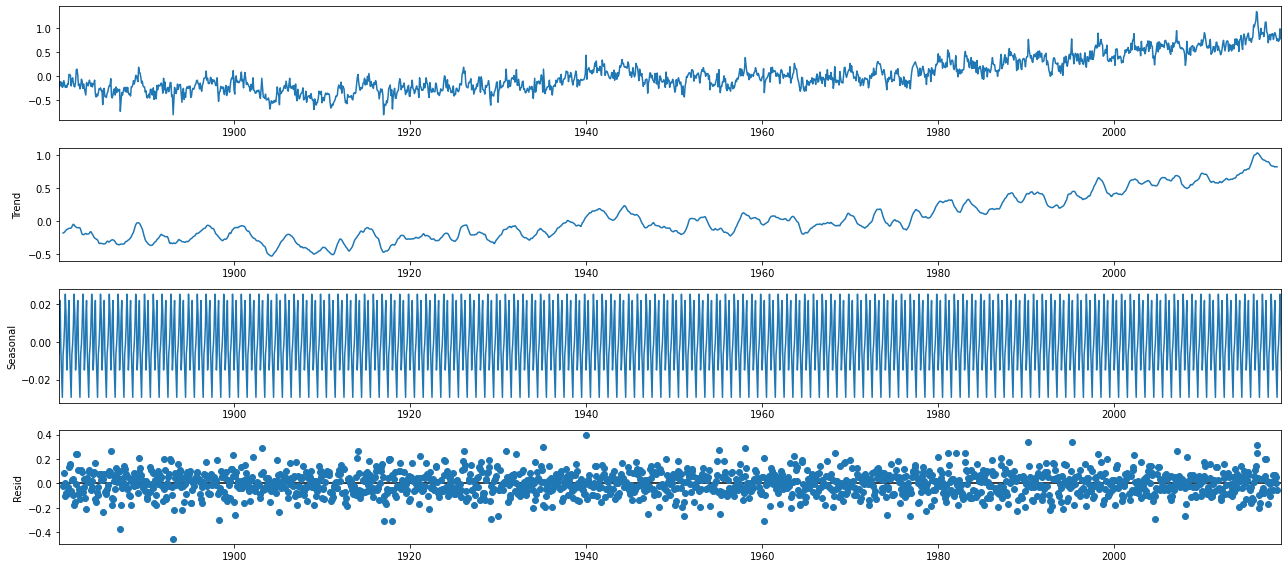

In [8]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_plot, model='additive')
fig = decomposition.plot()
plt.show()

In [12]:
# We can set the uncertainty interval to 95% (interval_width=0.95), the Prophet default is 80%
model = Prophet()
model.fit(dff)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[Here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) is a reference to the acceptable freq parameter aliases

In [48]:
# como quiero los proximos 50 años mi periodo es de 50 con una frecuencia de años
future = model.make_future_dataframe(periods=100, freq='Y')
future.tail()

,ds
1763,2114-12-31
1764,2115-12-31
1765,2116-12-31
1766,2117-12-31
1767,2118-12-31


Prophet returns a large DataFrame with many interesting columns, but we subset our output to the columns most relevant to forecasting, which are:

- ds: the datestamp of the forecasted value
- yhat: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
- yhat_lower: the lower bound of our forecasts
- yhat_upper: the upper bound of our forecasts


A variation in values from the output presented above is to be expected as Prophet relies on Markov chain Monte Carlo (MCMC) methods to generate its forecasts. MCMC is a stochastic process, so values will be slightly different each time.


#### leer algo mas de las cadenas de monte carlo que las tengo algo oxidadas

In [55]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1763,2114-12-31,2.479604,1.868608,3.080499
1764,2115-12-31,2.492805,1.873347,3.081129
1765,2116-12-31,2.524102,1.895816,3.151862
1766,2117-12-31,2.537053,1.901646,3.188517
1767,2118-12-31,2.550128,1.917850,3.156503


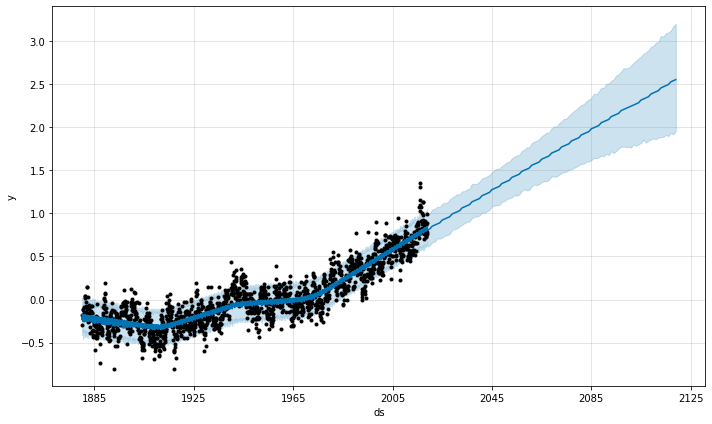

In [50]:
fig1 = model.plot(forecast)

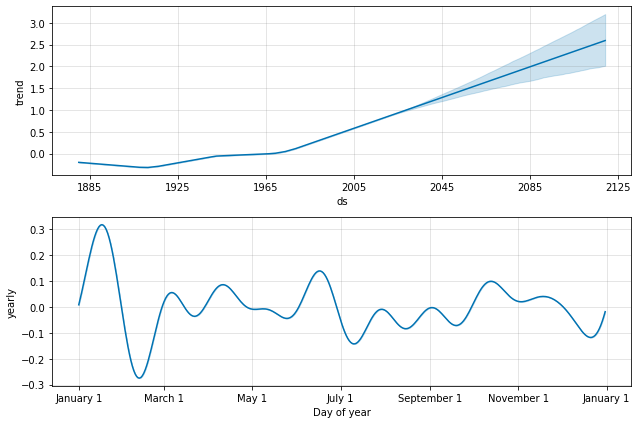

In [51]:
fig2 = model.plot_components(forecast)

In [52]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [25]:
plot_components_plotly(model, forecast)